In [5]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [588]:
%autoreload
%matplotlib inline

import numpy as np
import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectrum as spectrum
import darkhistory.spec.spectra as spectra
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tfl
import matplotlib
import matplotlib.pyplot as plt
import pickle

np.set_printoptions(threshold=np.nan)
matplotlib.rcParams['figure.figsize'] = [10,10]


from scipy import integrate
from astropy.io import fits
from tqdm import tqdm_notebook as tqdm

In [589]:
# test = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/transfer_func_table.raw","rb"))
transfer_func_table = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/tfunclist_photspec.raw", "rb"))

In [590]:
eng = transfer_func_table.in_eng
tf_rs_arr = transfer_func_table.rs

In [592]:
print(eng)

[  3.07055596e+03   3.21164435e+03   3.35924883e+03   3.51367344e+03
   3.67523670e+03   3.67612952e+03   3.84524915e+03   4.02219870e+03
   4.20734528e+03   4.40107368e+03   4.60378720e+03   4.81590859e+03
   5.03788108e+03   5.27016937e+03   5.51326073e+03   5.76766622e+03
   6.03392182e+03   6.31258980e+03   6.60426003e+03   6.90955145e+03
   7.22911360e+03   7.56362822e+03   7.91381094e+03   8.28041313e+03
   8.28510952e+03   8.66936132e+03   9.07169160e+03   9.49297470e+03
   9.93412938e+03   1.03961213e+04   1.08799656e+04   1.13867298e+04
   1.19175364e+04   1.24735663e+04   1.30560622e+04   1.36663317e+04
   1.43057515e+04   1.49757711e+04   1.56779174e+04   1.56951267e+04
   1.64326223e+04   1.72056994e+04   1.80161592e+04   1.88659012e+04
   1.97569299e+04   2.06913609e+04   2.16714275e+04   2.26994887e+04
   2.37780369e+04   2.49097060e+04   2.60972811e+04   2.73437075e+04
   2.73963293e+04   2.87096531e+04   3.00887051e+04   3.15370218e+04
   3.30583510e+04   3.46566661e+04

In [593]:
#Initialize
eng_ind = 299
mwimp = eng[eng_ind]
# in_eng_step = 500
# low_in_eng_absc = 3e3 + 100.
# upp_in_eng_absc = 5e3 * np.exp(39 * np.log(1e13/5e3) / 40)
# mwimp_array = low_in_eng_absc * np.exp((np.arange(in_eng_step)) * 
#               np.log(upp_in_eng_absc/low_in_eng_absc) / in_eng_step)

# mwimp = mwimp_array[eng_ind]

coarsen_factor = 1

rs_list = np.exp(np.arange(np.log(tf_rs_arr[0]), 
                           np.log(tf_rs_arr[1]), 
                           -transfer_func_table.dlnz*coarsen_factor)
                )

# Initial injection is 2 photons, to match up with what we have in file.
photon_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                        np.array([mwimp]), 
                                        eng)
                                       
photon_spec_init.rs = rs_list[0]
photon_spec_init.in_eng = mwimp
print(mwimp)

1060819228.22


In [594]:
if coarsen_factor > 1:
    transfer_func_table.coarsen(coarsen_factor, delete_tfs=False)

In [595]:
transfer_func_table.at_val('rs',rs_list)

In [605]:
photon_spectra = spectools.evolve(photon_spec_init, transfer_func_table, save_steps=True)
fin_phot_spec = spectools.evolve(photon_spec_init, transfer_func_table, end_rs=13)

In [606]:
file_name = {99: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_5.328E+00_xe_1.000E-04.fits",
            199: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_7.183E+00_xe_1.000E-04.fits",
            298: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.020E+00_xe_1.000E-04.fits",
            299: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.038E+00_xe_1.000E-04.fits", 
            399: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.089E+01_xe_1.000E-04.fits",
            499: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.275E+01_xe_1.000E-04.fits",
            2993: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_18_logE_9.038E+00_xe_1.000E-04.fits"}

file = fits.open(file_name[eng_ind])

file_eng = file[1].data['energy'][0,:]
file_rs = file[1].data['redshift'][0,:]
file_photonspectrum = file[1].data['photonspectrum'][0,:,:]

In [609]:
file_eng

array([  1.03047789e-04,   1.09424870e-04,   1.16196595e-04,
         1.23387385e-04,   1.31023175e-04,   1.39131504e-04,
         1.47741615e-04,   1.56884559e-04,   1.66593311e-04,
         1.76902887e-04,   1.87850468e-04,   1.99475536e-04,
         2.11820018e-04,   2.24928435e-04,   2.38848062e-04,
         2.53629101e-04,   2.69324860e-04,   2.85991946e-04,
         3.03690469e-04,   3.22484260e-04,   3.42441099e-04,
         3.63632961e-04,   3.86136275e-04,   4.10032200e-04,
         4.35406916e-04,   4.62351939e-04,   4.90964446e-04,
         5.21347630e-04,   5.53611067e-04,   5.87871118e-04,
         6.24251341e-04,   6.62882943e-04,   7.03905250e-04,
         7.47466209e-04,   7.93722925e-04,   8.42842224e-04,
         8.95001256e-04,   9.50388133e-04,   1.00920261e-03,
         1.07165680e-03,   1.13797595e-03,   1.20839924e-03,
         1.28318066e-03,   1.36258990e-03,   1.44691336e-03,
         1.53645514e-03,   1.63153820e-03,   1.73250544e-03,
         1.83972100e-03,

In [607]:
file_spectra = spectra.Spectra([spectrum.Spectrum(file_eng, photspec, rs=rs) 
                   for photspec,rs in zip(file_photonspectrum, file_rs)])

[0.0001, 10000000000000.0, 1e-22, 1000.0]

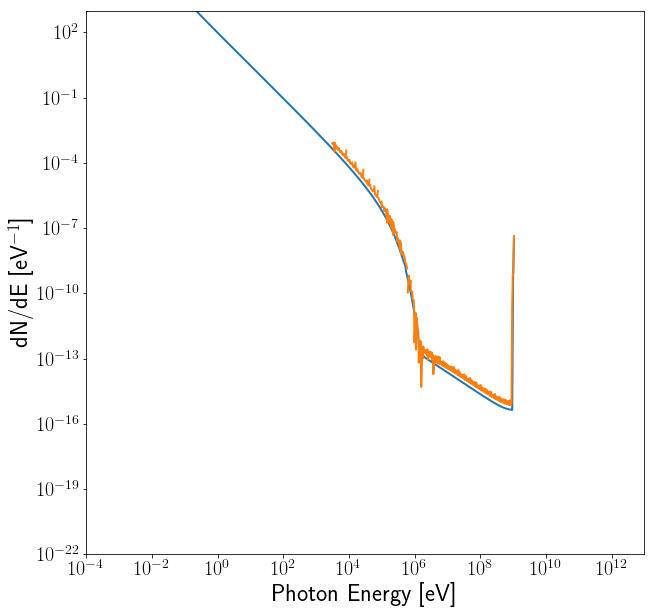

In [608]:
# rs_to_plot = 30.91

# file_spectra.rebin(photon_spectra.eng)

# photon_spectra.rebin(file_spectra.eng)


ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

file_spectra.plot(ax, ind=1, indtype='ind', linewidth=2)
photon_spectra.plot(ax, ind=1, indtype='ind', linewidth=2)

# file_spectra.plot(ax, ind=rs_to_plot, indtype='rs', linewidth=2)
# photon_spectra.plot(ax, ind=rs_to_plot, indtype='rs', linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/dE [eV$^{-1}$]',fontsize=24)
plt.axis([1e-4, 1e13, 1e-22, 1e3])


In [501]:
test = photon_spectra[1]
ref = file_spectra[1]
print(ref.totN())
ref.rebin(photon_spectra.eng)
print(ref.totN())
# print(file_spectra[1])
# utils.compare_arr([ref.eng, ref.N, test.eng, test.N])

2014.66624458
2014.66622668


/Users/hongwan/GitHub/DarkHistory/darkhistory/spec/spectrum.py:350: RuntimeWarning: divide by zero encountered in true_divide
  invSpec = Spectrum(self.eng, 1/self.dNdE, self.rs, self.in_eng)
/Users/hongwan/GitHub/DarkHistory/darkhistory/spec/spectrum.py:262: RuntimeWarning: invalid value encountered in multiply
  self.eng, self.dNdE*other.dNdE, self.rs, self.in_eng


[1000.0, 10000000000.0, 0.001, 100000.0]

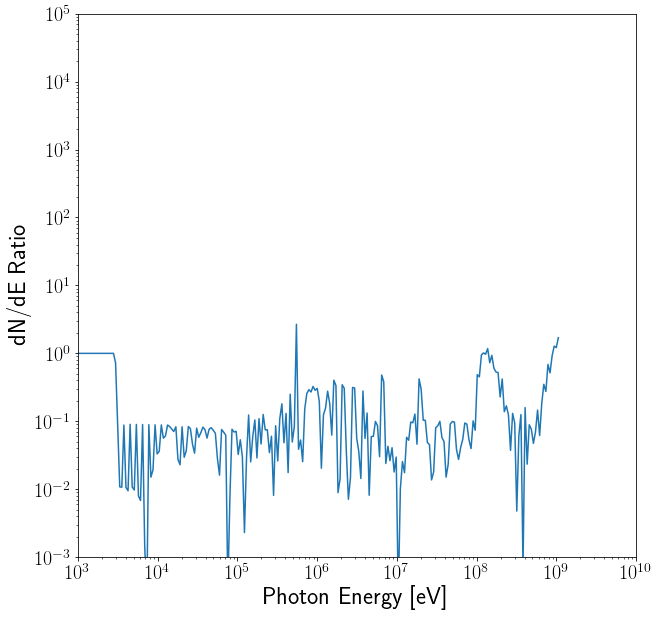

In [14]:
file_spectra = file_spectra.at_rs(photon_spectra.get_rs(), bounds_err=False)

ratio = (photon_spectra-file_spectra)/file_spectra

ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

ratio.plot(ax, ind=50, abs_plot=True, indtype='ind')
ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/dE Ratio',fontsize=24)
plt.axis([1e3, 1e10, 1e-3, 1e5])

In [15]:
utils.compare_arr([file_spectra[1].eng, file_spectra[1].dNdE, photon_spectra[1].dNdE])
print(file_spectra[1].rs)

[[  1.03047789e-04   1.47991345e+03   0.00000000e+00]
 [  1.09424870e-04   1.57009802e+03   0.00000000e+00]
 [  1.16196595e-04   1.66571875e+03   0.00000000e+00]
 [  1.23387385e-04   1.76709180e+03   0.00000000e+00]
 [  1.31023175e-04   1.87455676e+03   0.00000000e+00]
 [  1.39131504e-04   1.98846436e+03   0.00000000e+00]
 [  1.47741615e-04   2.10919092e+03   0.00000000e+00]
 [  1.56884559e-04   2.23712793e+03   0.00000000e+00]
 [  1.66593311e-04   2.37269092e+03   0.00000000e+00]
 [  1.76902887e-04   2.51631616e+03   0.00000000e+00]
 [  1.87850468e-04   2.66846191e+03   0.00000000e+00]
 [  1.99475536e-04   2.82961182e+03   0.00000000e+00]
 [  2.11820018e-04   3.00027246e+03   0.00000000e+00]
 [  2.24928435e-04   3.18097632e+03   0.00000000e+00]
 [  2.38848062e-04   3.37227856e+03   0.00000000e+00]
 [  2.53629101e-04   3.57476709e+03   0.00000000e+00]
 [  2.69324860e-04   3.78905981e+03   0.00000000e+00]
 [  2.85991946e-04   4.01579199e+03   0.00000000e+00]
 [  3.03690469e-04   4.25563